<a href="https://colab.research.google.com/github/johanesPao/tensorflow_developer_certificate/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problem (seq2seq).

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ee3a9ea8-3e28-d8ac-9d9b-144dd23b9c81)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, plot_loss_curves, compare_historys

# Install, import and login to wandb for model monitoring
!pip install wandb
import wandb as wb
wb.login(key='924d78a46727fe1fb5374706bf1b8a158fe73971')

--2022-06-23 10:00:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-23 10:00:43 (68.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 181 kB 71.5 MB/s 
     |████████████████████████████████| 145 kB 69.0 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

See the original source here: https://www.kaggle.com/competitions/nlp-getting-started/

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

--2022-06-23 10:00:56--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.103.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2022-06-23 10:00:56 (80.1 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [4]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples

for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f'Target: {target}', '(real disaster)' if target > 0 else '(not real disaster)')
  print(f'Text:\n{text}\n')
  print('---\n')

Target: 1 (real disaster)
Text:
A [small] flood with bigåÊconsequences https://t.co/CVPdVHxd1R http://t.co/FDMXP4FcMo

---

Target: 0 (not real disaster)
Text:
Apollo Brown ÛÒ Detonate ft.åÊM.O.P. http://t.co/JD7rIK7fX0 http://t.co/h6NgSw9A5b

---

Target: 0 (not real disaster)
Text:
China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/Ox3qb15LWQ | https://t.co/8u07FoqjzW http://t.co/tg5fQc8zEY

---

Target: 0 (not real disaster)
Text:
Hw18 going 90-100. Dude was keeping up with me. Took the same exit. Pulled to the side and told me he blew his motor. Lolol #2fast2furious

---

Target: 1 (real disaster)
Text:
@CochiseCollege For the people who died in Human Experiments by Unit 731 of Japanese military http://t.co/vVPLFQv58P http://t.co/ldx9uKNGsk

---



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation split
                                                                            random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - creaet a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [14]:
train_sentences[:15]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt',
       'Lava Dragon Breeder! I just bred a 

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=max_vocab_length, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None, # create groups of n-words?
                                    output_mode='int', # how to map tokens to number
                                    output_sequence_length=max_length, # how long do you want your sequences to be
                                    pad_to_max_tokens=True)

In [16]:
len(train_sentences[0].split())

7

In [17]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original text:\n{random_sentence}\
      \n\nVectorized version:')
text_vectorizer([random_sentence])

Original text:
Advice from Noah: Dont go running in a thunderstorm      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[6258,   20,    1,   63,  112,  876,    4,    3,  283,    0,    0,
           0,    0,    0,    0]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating and Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [22]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             input_length=max_length # how long is each input
                             )

embedding

In [23]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
      \n\nEmbedded version:')

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 AmazonDeals: Skylanders Trap Team: Flip Wreck Character Pack - down 4.53% ($0.45) to $9.49 from $9.94 #Sale http://t.co/pMbuzfGIn3      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02339908, -0.03093719,  0.00341942, ..., -0.01490133,
          0.01686365,  0.01033833],
        [-0.04071978,  0.01215009, -0.03647033, ..., -0.00093181,
         -0.00442689, -0.02755367],
        [-0.04240475,  0.00018401,  0.02099759, ..., -0.00188972,
         -0.00961653, -0.01926873],
        ...,
        [-0.02339908, -0.03093719,  0.00341942, ..., -0.01490133,
          0.01686365,  0.01033833],
        [ 0.00511731,  0.01857847, -0.02075355, ..., -0.03871964,
         -0.01130636, -0.01966457],
        [-0.02339908, -0.03093719,  0.00341942, ..., -0.01490133,
          0.01686365,  0.01033833]]], dtype=float32)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-2.33990792e-02, -3.09371948e-02,  3.41942161e-03, -3.53368148e-02,
        -3.88358459e-02, -3.10574304e-02, -2.03718990e-03, -7.83716515e-03,
         1.53062977e-02, -4.00929563e-02,  3.41788270e-02, -3.73862498e-02,
        -7.18459487e-05,  2.37580054e-02,  9.91177559e-03, -1.05467662e-02,
         4.37189229e-02,  1.59930438e-04,  4.26793434e-02,  4.15933467e-02,
         8.24836642e-03,  1.71703137e-02, -1.96311120e-02,  2.01748870e-02,
         2.84448005e-02,  4.61764224e-02,  2.34437473e-02, -1.20095015e-02,
         4.70465459e-02,  1.66506805e-02,  2.28720196e-02, -2.43412741e-02,
         5.27856499e-03,  2.96086706e-02, -2.00415254e-02, -3.19667682e-02,
        -8.40724632e-03, -2.05543637e-02, -2.17992067e-02, -1.60146579e-02,
        -2.35738605e-03,  4.48349006e-02,  9.20761377e-04,  3.40626575e-02,
        -7.22933933e-03, -2.27587949e-02, -3.73144858e-02, -2.02113278e-02,
        -2.44505163e-02, -1.02972612e-0

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate a model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑 **Note:** It's common practice to use non-DL algorithms as a baseline because of their speedn and then later using DL  to see if you can improve upon them.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), # convert words to numbers using tfidf
                    ('clf', MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%')

Our baseline model achieves an accuracy of: 79.27%


In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and coould easily be fixed with a function.

Let's create one to compare our model's prediction with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the sklearn docs: http://scikit-learn.org/stable/modules/model_evaluation.html

In [28]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # clr = classification_report(y_true=y_true, 
  #                             y_pred=y_pred,
  #                             output_dict=True)
    
  # output = {}

  # for item in clr.items():
  #   if item[0] == 'accuracy':
  #     break
  #   output[item[0]] = item[1]
    
  # output_df = pd.DataFrame.from_dict(output, orient='index')
  # return output_df

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results

In [29]:
# Get baseline results
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [30]:
# Setup wandb init and config
wb.init(project = 'nlp_tensorflow',
        entity = 'jpao',
        name='simple_dense_model',
        config={'lr': 0.001,
                'epochs': 5})

wandb: Currently logged in as: jpao. Use `wandb login --relogin` to force relogin


In [31]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector with averaging
outputs = layers.Dense(1, activation='sigmoid')(x) # create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [32]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [33]:
# Compile model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [34]:
# Import WandbCallback
from wandb.keras import WandbCallback

# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=wb.config.epochs,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5
213/215 [============================>.] - ETA: 0s - loss: 0.6126 - accuracy: 0.6800

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100102-27b9mqs0/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220623_100102-27b9mqs0/files/model-best)... Done. 0.2s


215/215 [==============================] - 7s 16ms/step - loss: 0.6122 - accuracy: 0.6805 - val_loss: 0.5365 - val_accuracy: 0.7520 - _timestamp: 1655978471.0000 - _runtime: 9.0000
Epoch 2/5
213/215 [============================>.] - ETA: 0s - loss: 0.4414 - accuracy: 0.8204INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100102-27b9mqs0/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220623_100102-27b9mqs0/files/model-best)... Done. 0.2s


215/215 [==============================] - 4s 19ms/step - loss: 0.4411 - accuracy: 0.8205 - val_loss: 0.4697 - val_accuracy: 0.7835 - _timestamp: 1655978475.0000 - _runtime: 13.0000
Epoch 3/5
215/215 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.8590INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100102-27b9mqs0/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220623_100102-27b9mqs0/files/model-best)... Done. 0.2s


215/215 [==============================] - 4s 20ms/step - loss: 0.3466 - accuracy: 0.8590 - val_loss: 0.4584 - val_accuracy: 0.7887 - _timestamp: 1655978479.0000 - _runtime: 17.0000
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2844 - accuracy: 0.8894 - val_loss: 0.4639 - val_accuracy: 0.7848 - _timestamp: 1655978483.0000 - _runtime: 21.0000
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2371 - accuracy: 0.9124 - val_loss: 0.4803 - val_accuracy: 0.7887 - _timestamp: 1655978485.0000 - _runtime: 23.0000


In [35]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4803 - accuracy: 0.7887


[0.480347603559494, 0.7887139320373535]

In [36]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

array([[3.93470764e-01],
       [7.73753583e-01],
       [9.97816563e-01],
       [8.69343877e-02],
       [1.01242222e-01],
       [9.44378138e-01],
       [9.03477609e-01],
       [9.93960619e-01],
       [9.64368224e-01],
       [2.21228361e-01],
       [1.15144342e-01],
       [6.62013531e-01],
       [5.65700606e-02],
       [2.23685279e-01],
       [4.16360190e-03],
       [1.36353076e-01],
       [2.64218505e-02],
       [7.52328113e-02],
       [2.10901007e-01],
       [5.32081962e-01],
       [9.16421711e-01],
       [4.49547917e-02],
       [3.92815530e-01],
       [7.32122883e-02],
       [9.58482146e-01],
       [9.98943269e-01],
       [2.91367657e-02],
       [6.72576725e-02],
       [2.96948105e-02],
       [2.30486453e-01],
       [5.18673539e-01],
       [2.11097017e-01],
       [4.90292937e-01],
       [2.19173551e-01],
       [5.03582180e-01],
       [5.51773421e-02],
       [9.93632019e-01],
       [1.19836323e-01],
       [3.21848840e-02],
       [9.98427153e-01],


In [37]:
# look at 1 single prediction
model_1_pred_probs[0]

array([0.39347076], dtype=float32)

In [38]:
# look at first 10 predictions
model_1_pred_probs[:10]

array([[0.39347076],
       [0.7737536 ],
       [0.99781656],
       [0.08693439],
       [0.10124222],
       [0.94437814],
       [0.9034776 ],
       [0.9939606 ],
       [0.9643682 ],
       [0.22122836]], dtype=float32)

In [39]:
val_labels

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [40]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [41]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'f1': 0.7856693843184869,
 'precision': 0.7939119079827037,
 'recall': 0.7887139107611548}

In [42]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Visualizing learned embeddings

In [43]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [45]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (output _dim of our embedding layer)

(10000, 128)


In [46]:
embed_weights

array([[ 0.02257613,  0.02387173, -0.01765832, ...,  0.01881059,
        -0.00206918,  0.02777044],
       [-0.02749138, -0.02489888, -0.00129858, ..., -0.01264973,
         0.01197137,  0.0086343 ],
       [ 0.00198747,  0.04603821, -0.05762012, ...,  0.0208854 ,
         0.02291605, -0.03021228],
       ...,
       [-0.01598613, -0.01263219, -0.01915867, ...,  0.04140515,
        -0.00720934,  0.03390853],
       [-0.03799692,  0.04198373, -0.0741844 , ...,  0.06052504,
        -0.08202314, -0.04411619],
       [-0.08822364,  0.0988978 , -0.09189889, ...,  0.0219486 ,
        -0.04191037, -0.06159967]], dtype=float32)

Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [47]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [48]:
# Download files from colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading the files above we can visualize them using http://projector.tensorflow.org/ and clicking the 'load' button on the left hand side.

> 📖 **Resources:** If you'd like to know more about embeddings, I'd encourage you to check out:
* Jay Alammar's visualized word2vec post: https://jalammar.github.io/illustrated-wrod2vec/
* TensorFlow's Word Embeddings guide: https://www.tensorflow.org/tutorials/text/word_embeddings

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> 📖 **Resources:** If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modelling lecture: https://youtu.be/QvkQ1B3FBqA
- Chris Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's the unreasonable effectiveness of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:
```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [49]:
# Create a LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
# print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [50]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [51]:
# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [52]:
# Setup wandb init and config
wb.init(project='nlp_tensorflow',
        entity='jpao',
        name='model_2_LSTM',
        config={'epochs': 5,
                'lr': 0.001,
                'valid_steps': 0.15})

# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=wb.config.epochs,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[WandbCallback()])

accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▇█▇█
val_loss,█▂▁▁▃
accuracy,0.91242
best_epoch,2
best_val_loss,0.45837
epoch,4
loss,0.23706
val_accuracy,0.78871


Epoch 1/5
215/215 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9213

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100130-1yiqtkal/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100130-1yiqtkal/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220623_100130-1yiqtkal/files/model-best)... Done. 0.1s


215/215 [==============================] - 11s 28ms/step - loss: 0.2232 - accuracy: 0.9213 - val_loss: 0.5197 - val_accuracy: 0.7808 - _timestamp: 1655978503.0000 - _runtime: 9.0000
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1576 - accuracy: 0.9418 - val_loss: 0.6768 - val_accuracy: 0.7848 - _timestamp: 1655978508.0000 - _runtime: 14.0000
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1293 - accuracy: 0.9499 - val_loss: 0.7031 - val_accuracy: 0.7835 - _timestamp: 1655978510.0000 - _runtime: 16.0000
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1046 - accuracy: 0.9603 - val_loss: 0.8583 - val_accuracy: 0.7756 - _timestamp: 1655978511.0000 - _runtime: 17.0000
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0856 - accuracy: 0.9680 - val_loss: 0.7940 - val_accuracy: 0.7717 - _timestamp: 1655978513.0000 - _runtime: 19.0000


In [53]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[0.02498212],
       [0.86061364],
       [0.9997148 ],
       [0.0884949 ],
       [0.00107101],
       [0.99713385],
       [0.86778826],
       [0.99979025],
       [0.99968684],
       [0.5877257 ]], dtype=float32)

In [54]:
# Convert model_2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0

In [55]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.16535433070865,
 'f1': 0.7705026760144871,
 'precision': 0.7717840407633899,
 'recall': 0.7716535433070866}

In [56]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [57]:
# Build a RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences=True
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [58]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [59]:
# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [60]:
# Setup wandb init and config
wb.init(project='nlp_tensorflow',
        entity='jpao',
        name='model_3_GRU',
        config={'lr': 0.001,
                'epochs': 5,
                'valid_steps': 0.15})

# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=wb.config.epochs,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[WandbCallback()])

accuracy,▁▄▅▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▆█▇▃▁
val_loss,▁▄▅█▇
accuracy,0.96803
best_epoch,0
best_val_loss,0.51972
epoch,4
loss,0.0856
val_accuracy,0.77165


Epoch 1/5
215/215 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9387

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100155-hxu6c3vc/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100155-hxu6c3vc/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220623_100155-hxu6c3vc/files/model-best)... Done. 0.2s


215/215 [==============================] - 15s 47ms/step - loss: 0.1556 - accuracy: 0.9387 - val_loss: 0.7309 - val_accuracy: 0.7808 - _timestamp: 1655978530.0000 - _runtime: 11.0000
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0813 - accuracy: 0.9696 - val_loss: 0.8085 - val_accuracy: 0.7769 - _timestamp: 1655978539.0000 - _runtime: 20.0000
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0697 - accuracy: 0.9736 - val_loss: 0.9555 - val_accuracy: 0.7717 - _timestamp: 1655978542.0000 - _runtime: 23.0000
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0595 - accuracy: 0.9756 - val_loss: 1.0320 - val_accuracy: 0.7808 - _timestamp: 1655978544.0000 - _runtime: 25.0000
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0540 - accuracy: 0.9765 - val_loss: 1.0879 - val_accuracy: 0.7743 - _timestamp: 1655978547.0000 - _runtime: 28.0000


In [61]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[6.9586337e-03],
       [6.4853501e-01],
       [9.9975759e-01],
       [7.3844433e-02],
       [1.4034033e-04],
       [9.9943429e-01],
       [6.0542119e-01],
       [9.9991834e-01],
       [9.9981672e-01],
       [9.7087371e-01]], dtype=float32)

In [62]:
# Convert model_3_pred_probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0

In [63]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.42782152230971,
 'f1': 0.7725974162749719,
 'precision': 0.7752857985262857,
 'recall': 0.7742782152230971}

In [64]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, bidirectional RNN goes from right to left as well as left to right.

In [65]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [66]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [67]:
# Compile model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [68]:
# Setup wandb init and config
wb.init(project='nlp_tensorflow',
        entity='jpao',
        name='model_4_bidirectional',
        config={'epochs': 5,
                'lr': 0.001,
                'valid_steps': 0.15})

# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=wb.config.epochs,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[WandbCallback()])

accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,█▅▁█▃
val_loss,▁▃▅▇█
accuracy,0.9765
best_epoch,0
best_val_loss,0.73086
epoch,4
loss,0.05399
val_accuracy,0.77428


Epoch 1/5
212/215 [============================>.] - ETA: 0s - loss: 0.1095 - accuracy: 0.9646

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100228-2w9eneii/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100228-2w9eneii/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220623_100228-2w9eneii/files/model-best)... Done. 0.1s


215/215 [==============================] - 16s 62ms/step - loss: 0.1089 - accuracy: 0.9647 - val_loss: 0.9966 - val_accuracy: 0.7664 - _timestamp: 1655978559.0000 - _runtime: 8.0000
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0525 - accuracy: 0.9784 - val_loss: 1.2403 - val_accuracy: 0.7612 - _timestamp: 1655978572.0000 - _runtime: 21.0000
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0463 - accuracy: 0.9791 - val_loss: 1.3189 - val_accuracy: 0.7625 - _timestamp: 1655978573.0000 - _runtime: 22.0000
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0464 - accuracy: 0.9791 - val_loss: 1.1147 - val_accuracy: 0.7559 - _timestamp: 1655978575.0000 - _runtime: 24.0000
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0403 - accuracy: 0.9804 - val_loss: 1.5170 - val_accuracy: 0.7638 - _timestamp: 1655978577.0000 - _runtime: 26.0000


In [69]:
# Make predicitons of the model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[1.05856096e-04],
       [7.26913989e-01],
       [9.99908686e-01],
       [2.97266338e-02],
       [7.02704665e-06],
       [9.94260788e-01],
       [1.44299325e-02],
       [9.99949217e-01],
       [9.99881864e-01],
       [1.77813590e-01]], dtype=float32)

In [70]:
# Convert model_4_pred_probs to label
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0

In [71]:
# Calculate model_4 results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'f1': 0.7580314598689414,
 'precision': 0.7741742901199562,
 'recall': 0.7637795275590551}

In [72]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Convolution Neural Neworks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've used Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):
```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)
* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t





In [73]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer(['this is a test sentence'])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also referred to as a ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1, # default
                        activation='relu',
                        padding='valid') # default = 'valid', the output is smaller than the input shape, 'same' means outputs is same shape as input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [74]:
# embedding_test

In [75]:
# conv_1d_output

In [76]:
# max_pool_output

In [77]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation='relu',
                  padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile Conv1D
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [78]:
# Setup wandb init and config
wb.init(project='nlp_tensorflow',
        entity='jpao',
        name='model_5_Conv1D',
        config={'epochs': 5,
                'lr': 0.001,
                'valid_steps': 0.15})

# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=wb.config.epochs,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[WandbCallback()])

accuracy,▁▇▇▇█
epoch,▁▃▅▆█
loss,█▂▂▂▁
val_accuracy,█▄▅▁▆
val_loss,▁▄▅▃█
accuracy,0.98044
best_epoch,0
best_val_loss,0.99664
epoch,4
loss,0.04031
val_accuracy,0.76378


Epoch 1/5
215/215 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9607

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100304-3ubz6kcu/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220623_100304-3ubz6kcu/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220623_100304-3ubz6kcu/files/model-best)... Done. 0.1s


215/215 [==============================] - 5s 15ms/step - loss: 0.1159 - accuracy: 0.9607 - val_loss: 0.9351 - val_accuracy: 0.7717 - _timestamp: 1655978594.0000 - _runtime: 6.0000
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0716 - accuracy: 0.9742 - val_loss: 1.1680 - val_accuracy: 0.7585 - _timestamp: 1655978597.0000 - _runtime: 9.0000
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0597 - accuracy: 0.9765 - val_loss: 1.1501 - val_accuracy: 0.7638 - _timestamp: 1655978598.0000 - _runtime: 10.0000
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0541 - accuracy: 0.9784 - val_loss: 1.2050 - val_accuracy: 0.7638 - _timestamp: 1655978599.0000 - _runtime: 11.0000
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0502 - accuracy: 0.9785 - val_loss: 1.2809 - val_accuracy: 0.7572 - _timestamp: 1655978600.0000 - _runtime: 12.0000


In [79]:
# Make predictions on model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[2.7028102e-02],
       [9.3317753e-01],
       [9.9994826e-01],
       [3.8675386e-02],
       [3.6913981e-08],
       [9.9568391e-01],
       [9.2696238e-01],
       [9.9996841e-01],
       [9.9999940e-01],
       [8.0846643e-01]], dtype=float32)

In [80]:
# Convert model_5_pred_probs to label
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0

In [81]:
# Calculate results of model_5
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.7217847769029,
 'f1': 0.7557133417830907,
 'precision': 0.7574646046920478,
 'recall': 0.7572178477690289}

In [82]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [83]:
sample_sentence

"There's a flood in my street!"

In [84]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence,
                      'When you call the universal sentence encoder on a sentence it turns it into numbers.'])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [85]:
embed_samples[0].shape

TensorShape([512])

In [86]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [87]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='model_6_USE')

In [88]:
# Compile
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [89]:
# Get a summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [90]:
# Setup wandb init and config
wb.init(project='nlp_tensorflow',
        entity='jpao',
        name='model_6_tfhub_USE_added_1_dense64',
        config={'epochs': 5,
                'lr': 0.001,
                'valid_steps': 0.15})

# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=wb.config.epochs,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[WandbCallback()])

accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,█▂▄▄▁
val_loss,▁▆▅▆█
accuracy,0.97854
best_epoch,0
best_val_loss,0.93506
epoch,4
loss,0.0502
val_accuracy,0.75722


Epoch 1/5
215/215 [==============================] - 10s 36ms/step - loss: 0.5094 - accuracy: 0.7783 - val_loss: 0.4514 - val_accuracy: 0.7979 - _timestamp: 1655978631.0000 - _runtime: 7.0000
Epoch 2/5
215/215 [==============================] - 7s 33ms/step - loss: 0.4146 - accuracy: 0.8127 - val_loss: 0.4424 - val_accuracy: 0.8071 - _timestamp: 1655978639.0000 - _runtime: 15.0000
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.4015 - accuracy: 0.8216 - val_loss: 0.4346 - val_accuracy: 0.8150 - _timestamp: 1655978646.0000 - _runtime: 22.0000
Epoch 4/5
215/215 [==============================] - 8s 35ms/step - loss: 0.3933 - accuracy: 0.8276 - val_loss: 0.4304 - val_accuracy: 0.8189 - _timestamp: 1655978654.0000 - _runtime: 30.0000
Epoch 5/5
215/215 [==============================] - 7s 32ms/step - loss: 0.3870 - accuracy: 0.8286 - val_loss: 0.4264 - val_accuracy: 0.8123 - _timestamp: 1655978661.0000 - _runtime: 37.0000


In [91]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.16753662],
       [0.75440913],
       [0.98702735],
       [0.1914817 ],
       [0.78197306],
       [0.7289524 ],
       [0.9835301 ],
       [0.9797767 ],
       [0.9471196 ],
       [0.12663187]], dtype=float32)

In [92]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [93]:
# Calculate model_6 results
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115121319063344,
 'precision': 0.812763224356635,
 'recall': 0.8123359580052494}

In [94]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [95]:
len(train_sentences)

6851

### Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [96]:
# ## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6ntrained on 100% data)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SETS

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

> 🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [97]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent)

685

In [98]:
# Check the number of each label in the updated training data subset
import numpy as np
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [99]:
# Check the number of target in our subset of data
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [100]:
# Create a model from TensorFlow Hub using USE the same as model_6
import tensorflow_hub as hub
sentence_encoder = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                  trainable=False,
                                  input_shape=[],
                                  dtype=tf.string)

model_7 = tf.keras.Sequential([
    sentence_encoder,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid', name='output_layer')
])

# Compile model_7
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [101]:
# Setup wandb init and config
wb.init(project='nlp_tensorflow',
        entity='jpao',
        name='model_7_USE_10_percent_data_correct_split',
        config={'epochs': 5,
                'lr': 0.001,
                'valid_steps': 0.15})

# Fit and train model_7 with 10 percent of data
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=wb.config.epochs,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[WandbCallback()])

accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▄▇█▆
val_loss,█▅▃▂▁
accuracy,0.82864
best_epoch,4
best_val_loss,0.4264
epoch,4
loss,0.38701
val_accuracy,0.81234


Epoch 1/5
22/22 [==============================] - 8s 261ms/step - loss: 0.6696 - accuracy: 0.7095 - val_loss: 0.6482 - val_accuracy: 0.7362 - _timestamp: 1655978694.0000 - _runtime: 6.0000
Epoch 2/5
22/22 [==============================] - 5s 231ms/step - loss: 0.5991 - accuracy: 0.8190 - val_loss: 0.5881 - val_accuracy: 0.7743 - _timestamp: 1655978699.0000 - _runtime: 11.0000
Epoch 3/5
22/22 [==============================] - 5s 234ms/step - loss: 0.5227 - accuracy: 0.8204 - val_loss: 0.5375 - val_accuracy: 0.7743 - _timestamp: 1655978704.0000 - _runtime: 16.0000
Epoch 4/5
22/22 [==============================] - 5s 227ms/step - loss: 0.4619 - accuracy: 0.8292 - val_loss: 0.5017 - val_accuracy: 0.7822 - _timestamp: 1655978709.0000 - _runtime: 21.0000
Epoch 5/5
22/22 [==============================] - 5s 222ms/step - loss: 0.4217 - accuracy: 0.8307 - val_loss: 0.4895 - val_accuracy: 0.7808 - _timestamp: 1655978714.0000 - _runtime: 26.0000


In [102]:
# Make predictions on model_7
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.19161858],
       [0.6051545 ],
       [0.9110247 ],
       [0.37491542],
       [0.5461665 ],
       [0.6862156 ],
       [0.87926126],
       [0.8112227 ],
       [0.85646415],
       [0.15894823]], dtype=float32)

In [103]:
# Convert model_7_pred_probs to label
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [104]:
# Calculate results of model_7
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'f1': 0.7790338643605079,
 'precision': 0.7823342077218286,
 'recall': 0.7808398950131233}

In [105]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [106]:
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115121319063344,
 'precision': 0.812763224356635,
 'recall': 0.8123359580052494}

## Comparing the performance of each of our models

In [107]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.871391,0.793912,0.788714,0.785669
2_lstm,77.165354,0.771784,0.771654,0.770503
3_gru,77.427822,0.775286,0.774278,0.772597
4_bidirectional,76.377953,0.774174,0.763780,0.758031
5_conv1d,75.721785,0.757465,0.757218,0.755713
6_tf_hub_use_encoder,81.233596,0.812763,0.812336,0.811512
7_tf_hub_use_encoder_10_percent,78.083990,0.782334,0.780840,0.779034


In [108]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

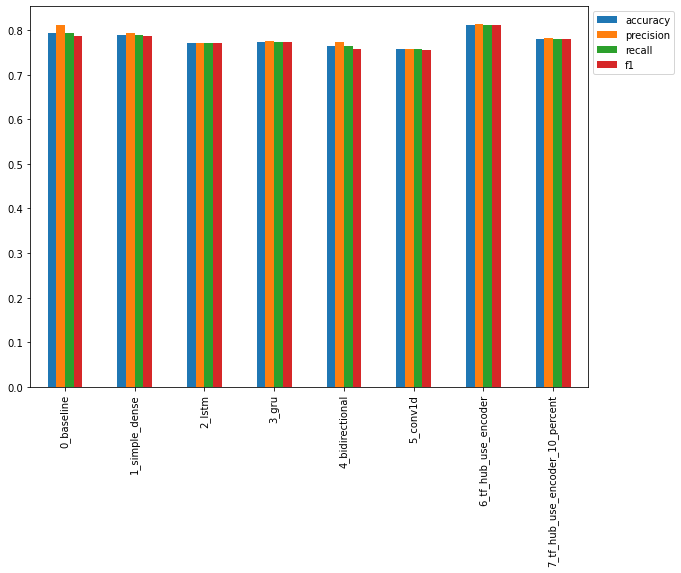

In [109]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

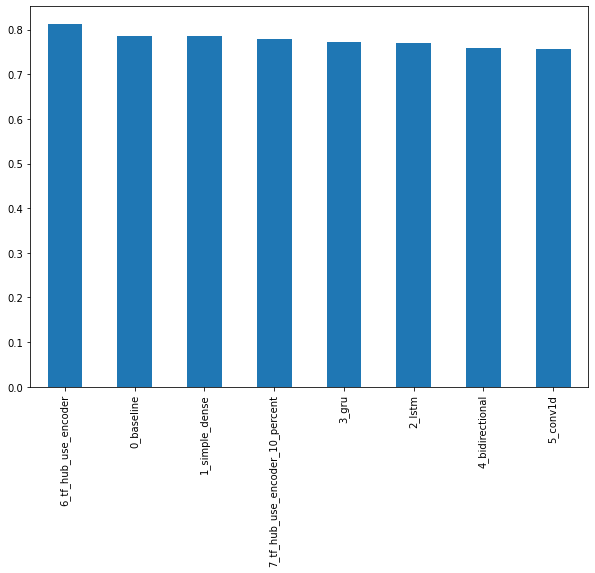

In [110]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

In [111]:
# best model result
model_6_results, model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 11ms/step - loss: 0.4264 - accuracy: 0.8123


({'accuracy': 81.23359580052494,
  'f1': 0.8115121319063344,
  'precision': 0.812763224356635,
  'recall': 0.8123359580052494},
 [0.42639580368995667, 0.8123359680175781])

In [112]:
# Save the best model (model_6)
model_6.save('tf_hub_use')

INFO:tensorflow:Assets written to: tf_hub_use/assets


INFO:tensorflow:Assets written to: tf_hub_use/assets


In [113]:
# Load the saved model
loaded_model = tf.keras.models.load_model('tf_hub_use')

In [114]:
# Check loaded_model evaluate, should be the same as model_6 evaluate
loaded_model.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4264 - accuracy: 0.8123


[0.42639580368995667, 0.8123359680175781]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those with prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [115]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-06-23 10:08:33--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 64.233.182.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   130MB/s    in 7.7s    

2022-06-23 10:08:41 (120 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables

In [116]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 25ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [117]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [120]:
# Create DataFrame with validation sentences, validation labels and best performing model predictions labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [121]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [122]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourselves of the target labels...
* `0` = not disaster
* `1` = disaster

In [123]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print('----\n')

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.8148159980773926
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

In [125]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print('----\n')

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.055075809359550476
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460336431860924
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054596975445747375
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963728412985802
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0

## Making predictions on the test dataset

In [128]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
    pred = tf.round(pred_prob)
    print(f'Pred: {int(pred)}, Prob: {pred_prob}')
    print(f'Text:\n{test_sample}\n')
    print('-----\n')

Pred: 0, Prob: 0.10395949333906174
Text:
#TornadoGiveaway åÊ #thebookclub åÊ Join in!! https://t.co/8qucf6sgOc https://t.co/5U1t8hc4uf

-----

Pred: 0, Prob: 0.15528739988803864
Text:
@RaynbowAffair Editor In Chief @DiamondKesawn Releases Issue #7 http://t.co/fa0Jt1Yqru of #RAmag. #Fashion #Models and #Mayhem

-----

Pred: 0, Prob: 0.28622299432754517
Text:
It's really sad that white people are quick to give money to desolate uneducated black ppl before educated blacks who are productive

-----

Pred: 1, Prob: 0.8910039663314819
Text:
Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/PuVOZi3Pa3

-----

Pred: 1, Prob: 0.9596754908561707
Text:
Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wedn...  http://t.co/KuBsM16OuD

-----

Pred: 0, Prob: 0.07191293686628342
Text:
@DanDoherty_ @TomCenci @HRWright too traumatised to ask why.....

-----

Pred: 1, Prob: 0.85738974809

### The speed/score tradeoff

In [131]:
# Let's make a function to measure the time spent on a prediction
import time
def pred_timer(model, samples):
    """
    Times how long a model takes to make predictions on samples.
    """
    start_time = time.perf_counter() # get start time
    model.predict(samples) # make predictions
    end_time = time.perf_counter() # get finish time
    total_time = end_time - start_time # calculate how long predictions took to make
    time_per_pred = total_time/len(samples)
    return total_time, time_per_pred

In [133]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                           samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.5038522959998772, 0.0006612234855641433)

In [134]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.04790359999969951, 6.286561679750592e-05)

In [135]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

Text(0, 0.5, 'F1-score')

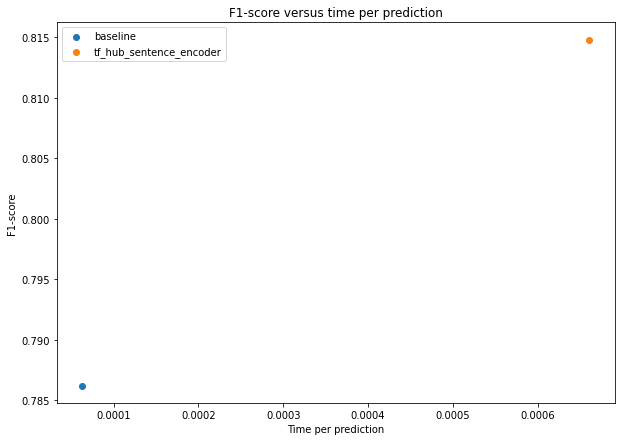

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_sentence_encoder')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1-score')